### The code in this notebook is borrowed from "TensorFlow Core" at: https://www.tensorflow.org/tutorials/text/nmt_with_attention  
### There may be some local change for study purposes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
import requests

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
# Download the file
# path_to_zip = tf.keras.utils.get_file(
#     fname = 'spa-eng.zip', 
#     origin = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', 
#     extract = True)
# filepath = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

In [3]:

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFKD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    w = re.sub(r'[""]', " ", w)
    
    # add space between chinese characters without affecting english letters
    w = re.sub(r'(?<=[^a-z\W\d_])(?=[^a-z\W\d_])', ' ', w)
    
    # replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
#     w = re.sub(r'[^a-zA-Z?.,!¿]', ' ', w)
    
    w.rstrip().strip()
    
    # add a start and an end token to the sentence
    # so that the model know when to start and stop
    w = '<start> ' + w + ' <end>'
    return w


#### Use this function when we have a dataset; use the fuction below for now
```python
# remove the accent & clean sentences & return word pairs [eng, spn]
def create_dataset(path, num_exmaples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_exmaples]]
    return zip(*word_pairs)
```

In [4]:
def create_dataset(url):
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content)
    lines = soup.find_all(class_="ltf")
    word_pairs = [[preprocess_sentence(w) for w in l.get_text().split('\n')] for l in lines]
#     return zip(*word_pairs)
    return word_pairs

In [5]:
url = "https://lyricstranslate.com/en/nǐ-zěnme-shuō-你怎么说-nǐ-zěnme-shuō.html"
aa, bb = create_dataset(url)
print(aa[-1])
print(bb[-1])

<start> 把 我 的 爱 情 还 给 我 <end>
<start> ba wo de aiqing hai gei wo <end>


In [6]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [7]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    # get word to index dictionary for sequences
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    # pad converted sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

In [8]:
def load_dataset(path, num_examples=None):
    inp_lang, targ_lang = create_dataset(path)
    
    inp_tensor, inp_token = tokenize(inp_lang)
    targ_tensor, targ_token = tokenize(targ_lang)
    return inp_tensor, targ_tensor, inp_token, targ_token

In [9]:
input_tensor, target_tensor, input_token, target_token = load_dataset(url)

In [10]:
max_length_input = max_length(input_tensor)
max_length_target = max_length(target_tensor)

In [11]:
input_tensor_train, input_tensor_valid, target_tensor_train, target_tensor_valid = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(input_tensor_valid), len(target_tensor_train), len(target_tensor_valid))

15 4 15 4


In [12]:
def convert(token, tensor):
    for t in tensor:
        if t != 0:
            print(f"{t} -----> {token.index_word[t]}")

In [13]:
print('Input index ------> input language')
print('==================================')
convert(input_token, input_tensor_train[0])
print()
convert(target_token, target_tensor_train[0])

Input index ------> input language
1 -----> <start>
3 -----> 我
8 -----> 没
12 -----> 忘
13 -----> 记
4 -----> 你
12 -----> 忘
13 -----> 记
3 -----> 我
2 -----> <end>

1 -----> <start>
3 -----> wo
32 -----> mei
7 -----> wangji
4 -----> ni
7 -----> wangji
3 -----> wo
2 -----> <end>


In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 4
steps_per_epoch = BUFFER_SIZE
embedding_dim = 256
units = 1024
vocab_input_size = len(input_token.word_index) + 1
vocab_target_size = len(target_token.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([4, 18]), TensorShape([4, 16]))

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (4, 18, 1024)
Encoder Hidden state shape: (batch size, units) (4, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (4, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (4, 18, 1)


In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (4, 43)


In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_token.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [31]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch, 
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5279
Epoch 1 Loss 0.3975
Time taken for 1 epoch 12.333699226379395 sec

Epoch 2 Batch 0 Loss 1.9679
Epoch 2 Loss 0.3724
Time taken for 1 epoch 0.5904898643493652 sec

Epoch 3 Batch 0 Loss 1.5696
Epoch 3 Loss 0.3768
Time taken for 1 epoch 0.36324214935302734 sec

Epoch 4 Batch 0 Loss 1.5693
Epoch 4 Loss 0.3518
Time taken for 1 epoch 0.5800333023071289 sec

Epoch 5 Batch 0 Loss 1.9701
Epoch 5 Loss 0.2999
Time taken for 1 epoch 0.363525390625 sec

Epoch 6 Batch 0 Loss 1.6155
Epoch 6 Loss 0.2899
Time taken for 1 epoch 0.5797200202941895 sec

Epoch 7 Batch 0 Loss 1.6660
Epoch 7 Loss 0.2959
Time taken for 1 epoch 0.3759157657623291 sec

Epoch 8 Batch 0 Loss 1.4842
Epoch 8 Loss 0.2666
Time taken for 1 epoch 0.5774383544921875 sec

Epoch 9 Batch 0 Loss 1.3169
Epoch 9 Loss 0.2591
Time taken for 1 epoch 0.3665773868560791 sec

Epoch 10 Batch 0 Loss 1.5690
Epoch 10 Loss 0.2759
Time taken for 1 epoch 0.6041281223297119 sec



In [32]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_target, max_length_input))
    print(f"max length target = {max_length_target}, max length input = {max_length_input}")  

    sentence = preprocess_sentence(sentence)
    print(sentence)

    inputs = [input_token.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_input,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_token.word_index['<start>']], 0)

    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_token.index_word[predicted_id] + ' '

        if target_token.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [33]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [34]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [35]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

max length target = 16, max length input = 18
<start> 你 心 我 <end>
Input: <start> 你 心 我 <end>
Predicted translation: ni <end> 


/home/franklu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/franklu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24515 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/franklu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/franklu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 20320 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/franklu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 24515 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/franklu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backen

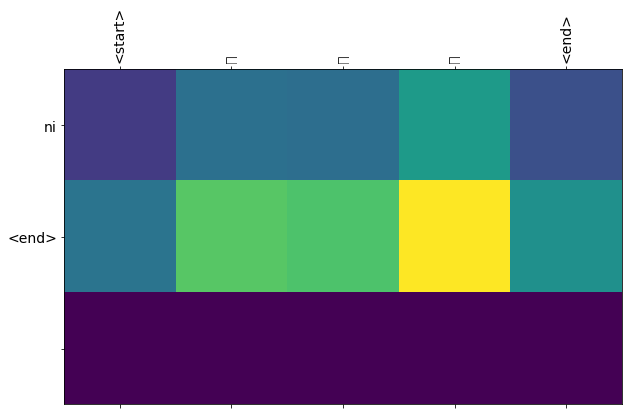

In [36]:
translate('你心我')